In [1]:
import os
import time
import random
from pathlib import Path

import torch
from torchvision.models import vgg16_bn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
import numpy as np

import matplotlib.pyplot as plt

from model.HiIR import HiIR
import piq

In [2]:
# super_resolution_manga_full_v3.py

# -----------------------------
# 1. DATASET: MangaRestorationDataset
# -----------------------------
class MangaRestorationDataset(Dataset):
    """
    Dataset especializado para manga con:
      - Full B/W → 1 sample (grayscale patch)
      - Full color → 3 samples (one per channel, each replicated to 3-ch)
      - Hybrid    → 1 B/W sample + 3 color-channel samples
    """
    def __init__(self,
                 manga_root_dir: str,
                 patch_size: int = 64,
                 augmentation_factor: int = 1):
        super().__init__()
        self.patch_size = patch_size
        self.aug_factor = augmentation_factor

        # Collect all images
        self.image_paths = sorted(Path(manga_root_dir).rglob('*.png')) + \
                           sorted(Path(manga_root_dir).rglob('*.jpg'))
        if not self.image_paths:
            raise RuntimeError(f"[ERROR Dataset] No images in {manga_root_dir!r}")

        # Precompute “samples”: one entry per output image
        self.samples = []
        for p in self.image_paths:
            img = Image.open(p).convert('RGB')
            arr = np.array(img)
            h, w, _ = arr.shape
            half = w // 2

            # helper to test grayscale
            def is_gray(region):
                R, G, B = region[...,0], region[...,1], region[...,2]
                return np.all(R == G) and np.all(G == B)

            left, right = arr[:, :half], arr[:, half:]
            left_gray, right_gray = is_gray(left), is_gray(right)

            if left_gray and right_gray:
                # full B/W → one sample
                self.samples.append({'path': p, 'mode': 'full_bw'})
            elif (not left_gray) and (not right_gray):
                # full color → three channel-splits
                for c in range(3):
                    self.samples.append({'path': p, 'mode': 'full_color', 'ch': c})
            else:
                # hybrid:
                # figure out which half is colored
                if left_gray:
                    gray_half, color_half = 'left', 'right'
                else:
                    gray_half, color_half = 'right', 'left'
                # 1) B/W sample: mask away the color half
                self.samples.append({
                    'path': p,
                    'mode': 'hybrid_bw',
                    'color_half': color_half
                })
                # 2) 3 color-channel samples from the colored half
                for c in range(3):
                    self.samples.append({
                        'path': p,
                        'mode': 'hybrid_color',
                        'color_half': color_half,
                        'ch': c
                    })

    def __len__(self):
        return len(self.samples) * self.aug_factor

    def __getitem__(self, idx):
        base_idx = idx // self.aug_factor
        spec = self.samples[base_idx]
        img = Image.open(spec['path']).convert('RGB')
        arr = np.array(img)
        h, w, _ = arr.shape
        half = w // 2

        # Build the “HR” image according to mode:
        if spec['mode'] == 'full_bw':
            hr_arr = arr  # already grayscale in channels

        elif spec['mode'] == 'full_color':
            c = spec['ch']
            chan = arr[...,c]
            hr_arr = np.stack([chan]*3, axis=-1)

        elif spec['mode'] == 'hybrid_bw':
            # zero-out the colored half
            hr_arr = arr.copy()
            if spec['color_half'] == 'left':
                hr_arr[:, :half] = 0
            else:
                hr_arr[:, half:] = 0

        elif spec['mode'] == 'hybrid_color':
            # isolate the colored half, then channel-split
            hr_arr = np.zeros_like(arr)
            if spec['color_half'] == 'left':
                hr_arr[:, :half] = arr[:, :half]
            else:
                hr_arr[:, half:] = arr[:, half:]
            c = spec['ch']
            chan = hr_arr[...,c]
            hr_arr = np.stack([chan]*3, axis=-1)

        else:
            raise RuntimeError(f"Unknown mode {spec['mode']}")

        # now hr_arr is H×W×3 uint8; randomly crop a patch:
        img_hr = Image.fromarray(hr_arr.astype(np.uint8))
        if img_hr.width < self.patch_size or img_hr.height < self.patch_size:
            img_hr = img_hr.resize((self.patch_size, self.patch_size), Image.BICUBIC)

        x = random.randint(0, img_hr.width - self.patch_size)
        y = random.randint(0, img_hr.height - self.patch_size)
        img_hr = img_hr.crop((x, y, x + self.patch_size, y + self.patch_size))

        # bicubic ↓4
        lr_size = (self.patch_size // 4, self.patch_size // 4)
        img_lr = img_hr.resize(lr_size, Image.BICUBIC)

        # to Tensors in [0,1]
        hr_np = np.array(img_hr).astype(np.float32) / 255.0
        lr_np = np.array(img_lr).astype(np.float32) / 255.0
        hr_t = torch.from_numpy(hr_np.transpose(2,0,1))
        lr_t = torch.from_numpy(lr_np.transpose(2,0,1))

        return {
            'degraded': lr_t,
            'clean':    hr_t,
            'mode':     spec['mode'],
            'manga_name': spec['path'].stem
        }


# -----------------------------
# 2. MÉTRICAS: PSNR y SSIM (soporte batch)
# -----------------------------
def compute_metrics_tensor(sr: torch.Tensor, hr: torch.Tensor):
    psnr = piq.psnr(sr, hr, data_range=1.0, reduction='mean').item()
    ssim = piq.ssim(sr, hr, data_range=1.0, reduction='mean').item()
    return psnr, ssim

# -----------------------------
# 3. TRAINER: MangaTrainer
# -----------------------------

# — 3.1) funciones de loss adicionales  losses — 
def sobel_gradients(x):
    # assume x in [B,3,H,W], compute per-channel sobel
    sobel_x = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]],
                           dtype=x.dtype, device=x.device).view(1,1,3,3)
    sobel_y = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]],
                           dtype=x.dtype, device=x.device).view(1,1,3,3)
    # apply to each channel
    Gx = F.conv2d(x, sobel_x.repeat(3,1,1,1), padding=1, groups=3)
    Gy = F.conv2d(x, sobel_y.repeat(3,1,1,1), padding=1, groups=3)
    return Gx, Gy

def gradient_loss(sr, hr):
    Gx_sr, Gy_sr = sobel_gradients(sr)
    Gx_hr, Gy_hr = sobel_gradients(hr)
    return F.l1_loss(Gx_sr, Gx_hr) + F.l1_loss(Gy_sr, Gy_hr)

class PerceptualLoss(nn.Module):
    def __init__(self, device):
        super().__init__()
        vgg = vgg16_bn(pretrained=True).features[:16].eval().to(device)
        for p in vgg.parameters(): p.requires_grad = False
        self.vgg = vgg
        self.mean = torch.tensor([0.485,0.456,0.406],
                                 device=device).view(1,3,1,1)
        self.std  = torch.tensor([0.229,0.224,0.225],
                                 device=device).view(1,3,1,1)
    def forward(self, sr, hr):
        sr_n = (sr - self.mean)/self.std
        hr_n = (hr - self.mean)/self.std
        return F.mse_loss(self.vgg(sr_n), self.vgg(hr_n))


# — 3.2) MangaTrainer class — 
class MangaTrainer:
    """
    Trainer para dataset de manga con modelo HiIR:
    - Entrenamiento, validación, checkpoints y curvas de pérdida.
    """
    def __init__(self, model, train_dataset, val_dataset=None, device='cuda'):
        self.device = device if torch.cuda.is_available() else 'cpu'
        self.model = model.to(self.device)
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

        # AdamW
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=2e-4,
            betas=(0.9, 0.999),
            weight_decay=1e-2
        )
        # Scheduler: warm-up 50k, luego decaimiento 0.5 cada 200k
        self.total_steps = 0
        self.warmup_steps = 50_000
        self.decay_step = 200_000
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(
            self.optimizer,
            lr_lambda=self._lr_lambda
        )
        self.l1 = nn.L1Loss()
        self.mse = nn.MSELoss()
        self.perc = PerceptualLoss(self.device)

    def _lr_lambda(self, step):
        if step < self.warmup_steps:
            return float(step) / float(max(1, self.warmup_steps))
        else:
            num_decays = (step - self.warmup_steps) // self.decay_step
            return 0.5 ** num_decays

    def train_epoch(self, dataloader):
        self.model.train()
        running_loss = 0.0
        running_psnr = 0.0
        running_ssim = 0.0
        cnt = 0

        for batch in dataloader:
            lr = batch['degraded'].to(self.device)   # (B,3,p/4,p/4)
            hr = batch['clean'].to(self.device)      # (B,3,p,p)

            sr = self.model(lr)                      # (B,3,p,p)
            pixel_l = self.l1(sr, hr)
            mse_l   = self.mse(sr, hr)
            ssim_l  = 1.0 - piq.ssim(sr, hr,
                        data_range=1.0, reduction='mean')
            grad_l  = gradient_loss(sr, hr)
            perc_l  = self.perc(sr, hr)
            
            loss = pixel_l \
                 + 0.1*mse_l \
                 + 0.1*ssim_l \
                 + 0.2*grad_l \
                 + 0.01*perc_l
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            self.total_steps += 1

            running_loss += loss.item()
            with torch.no_grad():
                psnr_batch, ssim_batch = compute_metrics_tensor(sr, hr)
            running_psnr += psnr_batch
            running_ssim += ssim_batch
            cnt += 1

        return running_loss / cnt, running_psnr / cnt, running_ssim / cnt

    def validate(self, dataloader, max_batches=5):
        self.model.eval()
        val_loss = 0.0
        val_psnr = 0.0
        val_ssim = 0.0
        cnt = 0
        with torch.no_grad():
            for i, batch in enumerate(dataloader):
                if i >= max_batches:
                    break
                lr = batch['degraded'].to(self.device)
                hr = batch['clean'].to(self.device)
                sr = self.model(lr)
                pixel_l = self.l1(sr, hr)
                mse_l   = self.mse(sr, hr)
                ssim_l  = 1.0 - piq.ssim(sr, hr,
                            data_range=1.0, reduction='mean')
                grad_l  = gradient_loss(sr, hr)
                perc_l  = self.perc(sr, hr)
                
                loss = pixel_l \
                     + 0.1*mse_l \
                     + 0.1*ssim_l \
                     + 0.2*grad_l \
                     + 0.01*perc_l
                
                val_loss += loss.item()
                psnr_batch, ssim_batch = compute_metrics_tensor(sr, hr)
                val_psnr += psnr_batch
                val_ssim += ssim_batch
                cnt += 1
        if cnt == 0:
            return None, None, None
        return val_loss / cnt, val_psnr / cnt, val_ssim / cnt

    def train(self,
              num_epochs: int,
              batch_size: int,
              num_workers: int,
              save_path: str):
        """
        Entrena el modelo num_epochs épocas.
        Guarda checkpoints cada 10 épocas.
        Dibuja curva de pérdida al final.
        """
        train_loader = DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,        # 0 para ver errores en hilo principal
            pin_memory=True,
            drop_last=True
        )
        if self.val_dataset is not None:
            val_loader = DataLoader(
                self.val_dataset,
                batch_size=batch_size,
                shuffle=False,
                num_workers=0,
                pin_memory=True
            )
        else:
            val_loader = None

        train_losses, val_losses = [], []
        train_psnrs, val_psnrs = [], []
        train_ssims, val_ssims = [], []

        for epoch in range(1, num_epochs + 1):
            start_time = time.time()
            train_loss, train_psnr, train_ssim = self.train_epoch(train_loader)
            train_losses.append(train_loss)
            train_psnrs.append(train_psnr)
            train_ssims.append(train_ssim)

            if val_loader is not None:
                val_loss, val_psnr, val_ssim = self.validate(val_loader)
                val_losses.append(val_loss)
                val_psnrs.append(val_psnr)
                val_ssims.append(val_ssim)
                print(f"Época [{epoch}/{num_epochs}]  "
                      f"Train Loss: {train_loss:.6f}  "
                      f"Train PSNR: {train_psnr:.4f}  "
                      f"Train SSIM: {train_ssim:.4f}  "
                      f"Val Loss: {val_loss:.6f}  "
                      f"Val PSNR: {val_psnr:.4f}  "
                      f"Val SSIM: {val_ssim:.4f}  "
                      f"Tiempo: {time.time() - start_time:.1f}s")
            else:
                print(f"Época [{epoch}/{num_epochs}]  "
                      f"Train Loss: {train_loss:.6f}  "
                      f"Train PSNR: {train_psnr:.4f}  "
                      f"Train SSIM: {train_ssim:.4f}  "
                      f"Tiempo: {time.time() - start_time:.1f}s")

            if epoch % 10 == 0:
                ckpt_path = f"{save_path}_ep{epoch}.pth"
                torch.save(self.model.state_dict(), ckpt_path)
                print(f"🔖 Checkpoint guardado en: {ckpt_path}")

        torch.save(self.model.state_dict(),f"{save_path}_final.pth")
        print(f"✅ Modelo final guardado en: {save_path}")

        # Curva de pérdida
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
        if val_losses:
            plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
        plt.xlabel('Época')
        plt.ylabel('Loss (L1)')
        plt.title('Curva de Pérdida')
        plt.legend()
        plt.tight_layout()
        plt.savefig('training_curves.png', dpi=300)
        plt.close()
        print("📈 Curvas de pérdida guardadas en 'training_curves.png'")

        return train_losses, val_losses


# -----------------------------
# 8. VISUALIZACIÓN DE PÁGINA COMPLETA
# -----------------------------

def visualize_full_page(sr_model: nn.Module,
                        dataset: MangaRestorationDataset,
                        device: str,
                        patch_size: int,
                        window_size: int,
                        image_id: int):
    """
    Muestra una página completa tras simular:
      - full B/W   → nada que hacer
      - full color → split en 3 B/W + fuse
      - hybrid     → split en B/W half + 3 B/W color-half + fuse
    Luego ↓4 bicúbico, SR con el modelo, calcula PSNR/SSIM y muestra LR, SR y HR.
    """
    sr_model.eval()

    # — helper: detect grayscale on a region —
    def is_gray(arr: np.ndarray):
        R, G, B = arr[...,0], arr[...,1], arr[...,2]
        return np.all(R == G) and np.all(G == B)

    # 1) cargar full HR
    img_path = dataset.image_paths[image_id]
    pil = Image.open(img_path).convert('RGB')
    arr = np.array(pil)                        # H×W×3 uint8
    H, W, _ = arr.shape
    half = W // 2

    # 2) decidir caso
    left, right = arr[:, :half], arr[:, half:]
    left_gray, right_gray = is_gray(left), is_gray(right)

    if left_gray and right_gray:
        # — full B/W —
        hr_arr = arr.copy()

    elif (not left_gray) and (not right_gray):
        # — full color: split into 3 B/W then fuse —
        bw_splits = []
        for c in range(3):
            chan = arr[..., c]                     # H×W
            bw = np.stack([chan]*3, axis=-1)       # H×W×3
            bw_splits.append(bw)
        # fuse back: take channel-0 of each split as R,G,B
        channels = [bw[..., 0] for bw in bw_splits]
        hr_arr = np.stack(channels, axis=-1)      # H×W×3

    else:
        # — hybrid —
        # 2a) B/W half
        gray_arr = arr.copy()
        if left_gray:
            # color is on right
            gray_arr[:, half:] = 0
            color_half = 'right'
        else:
            gray_arr[:, :half] = 0
            color_half = 'left'

        # 2b) color half isolation
        color_arr = np.zeros_like(arr)
        if color_half == 'left':
            color_arr[:, :half] = arr[:, :half]
        else:
            color_arr[:, half:] = arr[:, half:]

        # split color half into 3 B/W
        bw_color = []
        for c in range(3):
            chan = color_arr[..., c]
            bw = np.stack([chan]*3, axis=-1)
            bw_color.append(bw)
        # fuse color-half
        color_fused = np.stack([bw[..., 0] for bw in bw_color], axis=-1)

        # final fused HR
        hr_arr = gray_arr + color_fused

    # 3) ahora hr_arr es H×W×3 float in [0..255]
    hr_arr = np.clip(hr_arr.astype(np.float32) / 255.0, 0, 1)

    # 4) alinear a múltiplo de (scale * patch_size * window_size)
    scale = 4
    P = patch_size * window_size
    align = scale * P
    new_W = W - (W % align)
    new_H = H - (H % align)
    if new_W != W or new_H != H:
        left_crop = (W - new_W)//2
        top_crop  = (H - new_H)//2
        hr_arr = hr_arr[top_crop:top_crop+new_H,
                        left_crop:left_crop+new_W]

    Hc, Wc, _ = hr_arr.shape

    # 5) degradación bicúbica ↓4
    img_hr = Image.fromarray((hr_arr*255).astype(np.uint8))
    lr_size = (Wc//4, Hc//4)
    img_lr = img_hr.resize(lr_size, resample=Image.BICUBIC)
    lr_arr = np.array(img_lr).astype(np.float32)/255.0

    # 6) tensores
    hr_t = torch.from_numpy(hr_arr.transpose(2,0,1)).unsqueeze(0).to(device)
    lr_t = torch.from_numpy(lr_arr.transpose(2,0,1)).unsqueeze(0).to(device)

    # 7) inferencia SR
    with torch.no_grad():
        sr_t = sr_model(lr_t)

    # 8) métricas
    psnr_full, ssim_full = compute_metrics_tensor(sr_t, hr_t)

    # 9) para mostrar
    lr_show = lr_t.squeeze(0).cpu().numpy().transpose(1,2,0)
    sr_show = sr_t.squeeze(0).cpu().numpy().transpose(1,2,0)

    fig, axs = plt.subplots(1,3,figsize=(18,8))
    axs[0].imshow(np.clip(lr_show,0,1))
    axs[0].set_title(f"LR ({lr_size[0]}×{lr_size[1]})")
    axs[0].axis("off")

    axs[1].imshow(np.clip(sr_show,0,1))
    axs[1].set_title(f"SR ({Wc}×{Hc})\nPSNR:{psnr_full:.2f}dB   SSIM:{ssim_full:.4f}")
    axs[1].axis("off")

    axs[2].imshow(np.clip(hr_arr,0,1))
    axs[2].set_title(f"HR ({Wc}×{Hc})")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()


Device: cuda
Cargando dataset
✅ Dataset cargado: total=11262, train=9009, val=2253 , Tiempo usado: 214.2s
🖼️  Modelo HiIR instanciado. Parámetros totales: 2,745,699


G:\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
G:\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🚀 Iniciando entrenamiento...
Época [1/120]  Train Loss: 0.816902  Train PSNR: 6.8178  Train SSIM: 0.0255  Val Loss: 0.810161  Val PSNR: 6.9085  Val SSIM: 0.0268  Tiempo: 239.4s
Época [2/120]  Train Loss: 0.810429  Train PSNR: 6.8527  Train SSIM: 0.0266  Val Loss: 0.805288  Val PSNR: 6.9172  Val SSIM: 0.0274  Tiempo: 236.3s
Época [3/120]  Train Loss: 0.798312  Train PSNR: 6.9130  Train SSIM: 0.0282  Val Loss: 0.791389  Val PSNR: 6.9983  Val SSIM: 0.0294  Tiempo: 231.5s
Época [4/120]  Train Loss: 0.781240  Train PSNR: 7.0414  Train SSIM: 0.0313  Val Loss: 0.767648  Val PSNR: 7.1820  Val SSIM: 0.0329  Tiempo: 237.6s
Época [5/120]  Train Loss: 0.759022  Train PSNR: 7.1711  Train SSIM: 0.0358  Val Loss: 0.748303  Val PSNR: 7.2998  Val SSIM: 0.0386  Tiempo: 242.5s
Época [6/120]  Train Loss: 0.734555  Train PSNR: 7.3314  Train SSIM: 0.0427  Val Loss: 0.722966  Val PSNR: 7.4849  Val SSIM: 0.0473  Tiempo: 239.1s
Época [7/120]  Train Loss: 0.705751  Train PSNR: 7.5763  Train SSIM: 0.0536  Val Lo

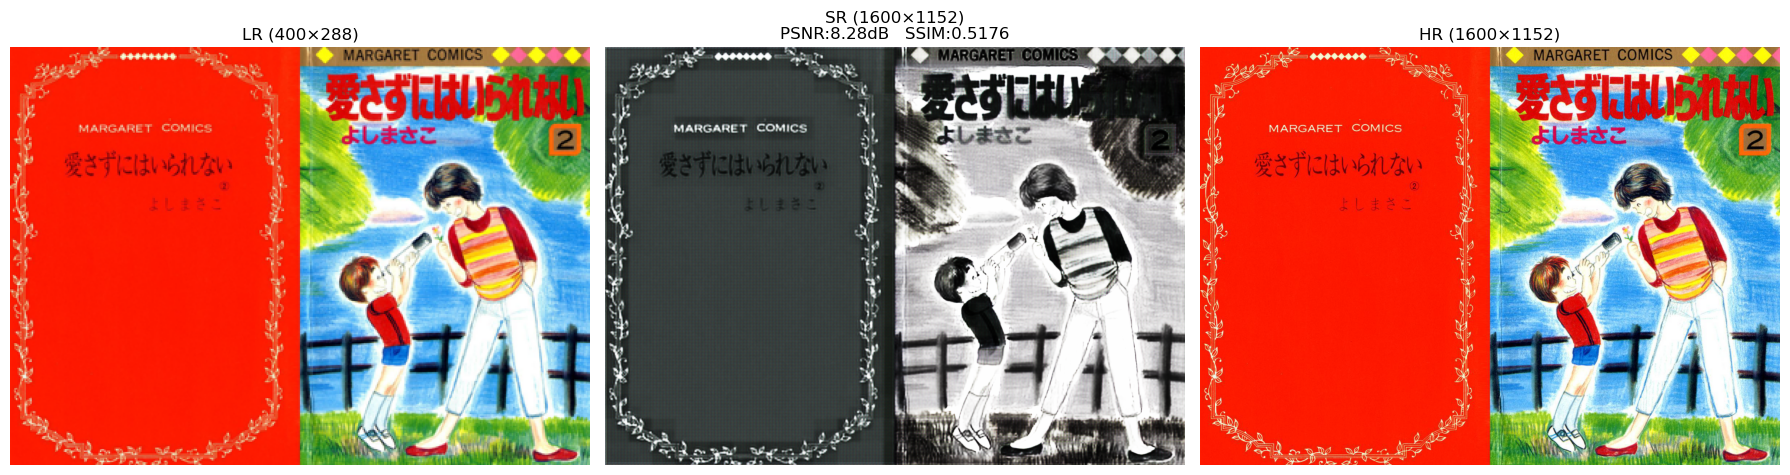

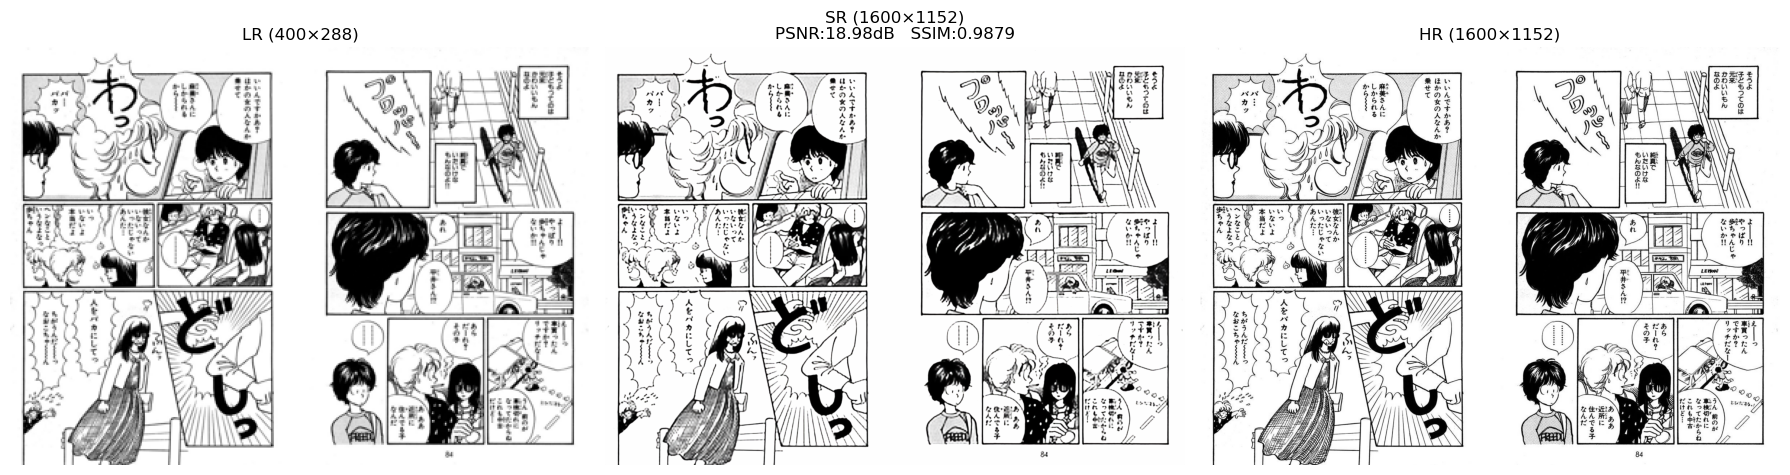

In [3]:
# -----------------------------
# 9. MAIN: Configuración, Entrenamiento y Visualización
# -----------------------------
def main():
    # Directorio raíz con imágenes de manga (subcarpetas anidadas)
    manga_root = r"G:\MaestriaInformatica\Tecnicas avanzadas\Trabajo_ grupal\Manga109_released_2023_12_07\images"

    # Parámetros de dataset
    patch_size = 64
    aug_factor = 1
    train_split = 0.8

    # Parámetros de entrenamiento
    batch_size = 256
    num_workers = 0   # usar 0 para debugging
    num_epochs = 120
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Device: {device}")
    # 9.1. Construir dataset y particionar
    print("Cargando dataset")
    start_dtst = time.time()
    try:
        full_dataset = MangaRestorationDataset(
            manga_root_dir=manga_root,
            patch_size=patch_size,
            augmentation_factor=aug_factor
        )
    except RuntimeError as e:
        print(f"[ERROR al crear dataset] {e}")
        return

    total_len = len(full_dataset)
    train_len = int(train_split * total_len)
    val_len = total_len - train_len
    train_ds, val_ds = random_split(
        full_dataset,
        [train_len, val_len],
        generator=torch.Generator().manual_seed(42)
    )
    print(f"✅ Dataset cargado: total={total_len}, train={train_len}, val={val_len} , Tiempo usado: {time.time() - start_dtst:.1f}s")

    # 9.2. Instanciar modelo HiIR
    model_args = dict(
        img_size=patch_size,
        in_chans=3,
        out_chans=3,
        embed_dim=96,
        depths=8,
        num_heads=6,
        patch_size=8,
        window_size=2,
        mlp_ratio=4.0,
        qkv_bias=True,
        dropout=0.0
    )
    
    model = HiIR(**model_args).to(device)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"🖼️  Modelo HiIR instanciado. Parámetros totales: {total_params:,}")

    # 9.3. Crear entrenador
    trainer = MangaTrainer(
        model=model,
        train_dataset=train_ds,
        val_dataset=val_ds,
        device=device
    )

    # 9.4. Entrenar
    print("🚀 Iniciando entrenamiento...")
    save_path = r"G:\MaestriaInformatica\Tecnicas avanzadas\Trabajo_ grupal\Models_v3\hiir_manga"
    trainer.train(
        num_epochs=num_epochs,
        batch_size=batch_size,
        num_workers=num_workers,
        save_path=save_path
    )

    # 9.5. Visualizar página completa
    print("\n🔍 Mostrando página completa de validación:")
    visualize_full_page(model, full_dataset, device, patch_size=model_args["patch_size"],window_size=model_args["window_size"],image_id=0)
    visualize_full_page(model, full_dataset, device, patch_size=model_args["patch_size"],window_size=model_args["window_size"],image_id=42)
    
if __name__ == "__main__":
    main()